# Trabajo Práctico N°2 - Rossmann Store Sales
## Germán Bertachini - Legajo 58750

# Respuestas teóricas

### 1. Entity Embeddings

Se trata de una herramienta de gran valor para mejorar el rendimiento de una RRNN. Consiste en un tipo de embedding para transformar variables categóricas(un tipo de dato) codificandolas en vectores continuos que sean más fáciles de optimizar ya que es mucho más sencillo trabajar sobre un vector numérico que con las definiciones categóricas específicas.

Un Embedding se puede ver también como un subresultado de una RRNN por si misma, ya que encuentra la manera óptima de relacionar las variables categóricas a un vector continuo. Se utilizan capas especiales de embedding. 

Para obtener estos embeddings se tiene una estructura de RRNN de varias etapas incluidas capas densas,capas de embedding, hot-eonding, entre otras.

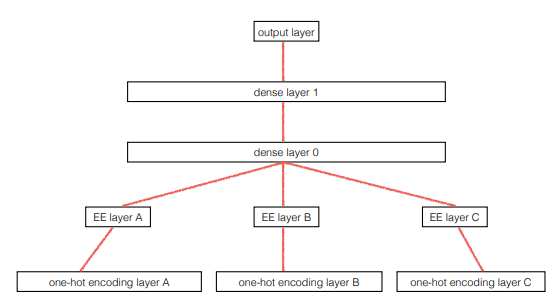

Se arranca realizando un hot-enconding para cada varible, asignando/codificando de manera única cada variable categórica que después va a una capa de embedding para luego ir a dos capas densas. Se ntrena la red con una función de costo como cualquier otra, funcióon que se quiere minimizar en post de obtener la mejor optimzaicón posible. Para este caso en paricular se busca optimizar la estimación de las ventas para cada tienda.

El resultado son los pesos de las capas de enmbeddings que están optimizados para esa clasificación, seindo el resultado final buscado, en realidad un subproducto del entrenamiento de mi red. A este proceso se lo denomina **transfer learning**, un tipo de preprocesamiento que me permite preoptimizar mi red. En la tabla debajo se puede observar el vector de entity embedding obtenido para cada variable categórica en **kaggle-rossmann**.

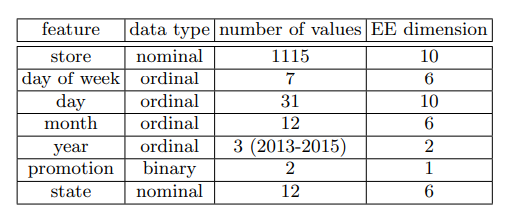

A modo de resumen, es un proceso de optimización que agarra variables categoricas y las tranforma en embeddings de entidades. En vez de usaar las variables categoricas (difíciles de procesar) entro con los vectores resultantes (fáciles de procesar). Implicando una reducción de dimensionalidad, como por ejemplo pasar de estados alemanes de 12 dimensiones(hot-encoding para cada posible vairable) a vectores de 6 dimensiones. Finalmente, se va a a tener que entrenar **m** dimensiones finales(tamaño del vector de embedding) por las **n** cantidad de variables categóricas, siendo estos mis pesos. Una vez entrenados se insertan en la RRNN definitiva en vez de las variables categóricas.


### 2. Métrica RMPSE

Se trata de métrica utilizada en esta competencia, RMPSE se refiere a *root mean square percentage error* para medir la calidad de nuestra estimación. Es la relación porcentual de error medio cuadrático aplicada la raíz, siendo el error la diferencia entre las ventas para un día y tienda en particular en comparación con las ventas estimadas, normalizando al valor real.



$$
\textrm{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

donde:

- $y_i$ las ventas de un día particular de un store
- $\hat{y}_i$ ventas estimadas por el modelo
- $n$ es el número de predicciones realizadas

## *Librerías a utilizar*

In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
import pandas as pd
import seaborn as sns
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from pandas_summary import DataFrameSummary

**Extraigo los datos**

In [2]:
PATH = 'rossmann/'
table_names = ['train', 'store', 'store_states', 'state_names', 'googletrend', 'weather']
train, store, store_states, state_names, googletrend, weather = [pd.read_csv(PATH + fname+'.csv', 
                                                                             low_memory=False) for fname in table_names]


# Preprocesamiento

En esta sección se buscará preprocesar los datos para que sean más fáciles de usar en nuestra red neuronal. Desde embeddings de variables categóricas hasta eliminar faltantes. Llegando a un dataset lo más completo y optimizado posible.

In [3]:
import pandas as pd
import numpy as np
import datetime
from isoweek import Week
from pandas_summary import DataFrameSummary
PATH = 'rossmann/'

In [4]:
table_names = ['train', 'test', 'store', 'store_states', 'state_names', 'googletrend', 'weather']
train, test, store, store_states, state_names, googletrend, weather = dfs = [pd.read_csv(PATH + fname+'.csv', 
                                                                             low_memory=False) for fname in table_names]

# Missing data 

In [5]:
def get_missing_columns(df):
    return list(df.columns[df.describe(include = 'all').loc['count']<len(df)])

In [6]:
display(train.head().T)
display(DataFrameSummary(train).summary())

,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31,2015-07-31,2015-07-31,2015-07-31,2015-07-31
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,1,1,1,1,1


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1017209.0,1017209.0,NaN,1017209.0,1017209.0,1017209.0,1017209.0,NaN,1017209.0
mean,558.429727,3.998341,NaN,5773.818972,633.145946,0.830107,0.381515,NaN,0.178647
std,321.908651,1.997391,NaN,3849.926175,464.411734,0.375539,0.485759,NaN,0.383056
min,1.0,1.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
25%,280.0,2.0,NaN,3727.0,405.0,1.0,0.0,NaN,0.0
50%,558.0,4.0,NaN,5744.0,609.0,1.0,0.0,NaN,0.0
75%,838.0,6.0,NaN,7856.0,837.0,1.0,1.0,NaN,0.0
max,1115.0,7.0,NaN,41551.0,7388.0,1.0,1.0,NaN,1.0
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2


Chequeo las columnas en las cuales falta información y las completo con información relevante.

In [7]:
for i, df in enumerate(dfs):
    print(table_names[i], get_missing_columns(df))

train []
test ['Open']
store ['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
store_states []
state_names []
googletrend []
weather ['Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM', 'Max_Gust_SpeedKm_h', 'CloudCover', 'Events']


In [8]:
# Si no es dia 7 esta abierto  (los domingos no abren) - Verificado que el store 622 esta usualmente cerrado el día 7
test.loc[test['Open'].isna(), 'Open'] = (test[test['Open'].isna()]['DayOfWeek'] != 7)*1.0

In [9]:
# Fechas de las mas antiguas segun datos y tambien las fechas anteriores las pongo como minimo en 1990
# Si no hay datos sobre el mes de apertura pongo Enero (1)
store.loc[store['CompetitionOpenSinceYear'].isna() | (store['CompetitionOpenSinceYear']<1990), 'CompetitionOpenSinceYear'] = np.int32(1990)
store.loc[store['CompetitionOpenSinceMonth'].isna() | (store['CompetitionOpenSinceYear']<1990), 'CompetitionOpenSinceMonth'] = np.int32(1)

In [10]:
# Si no tengo la distancia, pongo la máxima en el dataset (75860 en este caso)
print(store['CompetitionDistance'].max(), store['CompetitionDistance'].mean(), store['CompetitionDistance'].min())
store.loc[store['CompetitionDistance'].isna(), 'CompetitionDistance'] = store['CompetitionDistance'].max()

75860.0 5404.901079136691 20.0


In [11]:
# Si no tiene Promo2 entonces la semana en donde empezo es cero y el año es 1990. Esto será tratado como categórica por eso tiene sentido.
store.loc[(store['Promo2SinceWeek'].isna()) & (store['Promo2'] == 0), 'Promo2SinceWeek'] = np.int32(0)
store.loc[(store['Promo2SinceYear'].isna()) & (store['Promo2'] == 0), 'Promo2SinceYear'] = np.int32(1990.0)
store.loc[store['PromoInterval'].isna() & (store['Promo2'] == 0), 'PromoInterval'] = '-'

In [12]:
display(store.head(20).T)
display(DataFrameSummary(store).summary())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Store,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
StoreType,c,a,a,c,a,a,a,a,a,a,a,a,d,a,d,a,a,d,a,d
Assortment,a,a,a,c,a,a,c,a,c,a,c,c,a,a,c,c,a,c,c,a
CompetitionDistance,1270.0,570.0,14130.0,620.0,29910.0,310.0,24000.0,7520.0,2030.0,3160.0,960.0,1070.0,310.0,1300.0,4110.0,3270.0,50.0,13840.0,3240.0,2340.0
CompetitionOpenSinceMonth,9.0,11.0,12.0,9.0,4.0,12.0,4.0,10.0,8.0,9.0,11.0,1.0,1.0,3.0,3.0,1.0,12.0,6.0,1.0,5.0
CompetitionOpenSinceYear,2008.0,2007.0,2006.0,2009.0,2015.0,2013.0,2013.0,2014.0,2000.0,2009.0,2011.0,1990.0,1990.0,2014.0,2010.0,1990.0,2005.0,2010.0,1990.0,2009.0
Promo2,0,1,1,0,0,0,0,0,0,0,1,1,1,1,1,0,1,1,1,1
Promo2SinceWeek,0.0,13.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,45.0,40.0,14.0,0.0,26.0,14.0,22.0,40.0
Promo2SinceYear,1990.0,2010.0,2011.0,1990.0,1990.0,1990.0,1990.0,1990.0,1990.0,1990.0,2012.0,2010.0,2009.0,2011.0,2011.0,1990.0,2010.0,2012.0,2011.0,2014.0
PromoInterval,-,"Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct",-,-,-,-,-,-,-,"Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct","Feb,May,Aug,Nov","Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct",-,"Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct","Mar,Jun,Sept,Dec","Jan,Apr,Jul,Oct"


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115.0,NaN,NaN,1115.0,1115.0,1115.0,1115.0,1115.0,1115.0,NaN
mean,558.0,NaN,NaN,5594.466368,5.24843,2002.84843,0.512108,12.083408,2001.145291,NaN
std,322.01708,NaN,NaN,8479.266802,3.929836,9.540492,0.500078,15.542241,10.949224,NaN
min,1.0,NaN,NaN,20.0,1.0,1990.0,0.0,0.0,1990.0,NaN
25%,279.5,NaN,NaN,720.0,1.0,1990.0,0.0,0.0,1990.0,NaN
50%,558.0,NaN,NaN,2330.0,4.0,2006.0,1.0,1.0,2009.0,NaN
75%,836.5,NaN,NaN,6905.0,9.0,2011.0,1.0,22.0,2012.0,NaN
max,1115.0,NaN,NaN,75860.0,12.0,2015.0,1.0,50.0,2015.0,NaN
counts,1115,1115,1115,1115,1115,1115,1115,1115,1115,1115
uniques,1115,4,3,654,12,21,2,25,8,4


In [13]:
# Supongo que son dias tranquilos (de todas formas no se usaran para la predicción)
weather.loc[weather['Max_VisibilityKm'].isna(), 'Max_VisibilityKm'] = weather['Max_VisibilityKm'].max()
weather.loc[weather['Mean_VisibilityKm'].isna(), 'Mean_VisibilityKm'] = weather['Mean_VisibilityKm'].max()
weather.loc[weather['Min_VisibilitykM'].isna(), 'Min_VisibilitykM'] = weather['Min_VisibilitykM'].max()
weather.loc[weather['Max_Gust_SpeedKm_h'].isna(), 'Max_Gust_SpeedKm_h'] = weather['Max_Gust_SpeedKm_h'].min()
weather.loc[weather['CloudCover'].isna(), 'CloudCover'] = weather['CloudCover'].min()
weather.loc[weather['Events'].isna(), 'Events'] = 'Sunny'

In [14]:
display(weather.head())
display(DataFrameSummary(weather).summary())

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,21.0,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,21.0,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,21.0,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,21.0,0.00,7.0,Rain,268


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
count,NaN,NaN,15840.0,15840.0,15840.0,15840.0,15840.0,15840.0,15840.0,15840.0,...,15840.0,15840.0,15840.0,15840.0,15840.0,15840.0,15840.0,15840.0,NaN,15840.0
mean,NaN,NaN,14.644129,10.388952,6.19899,8.587816,6.205808,3.626136,93.659596,74.282891,...,24.224558,12.691035,7.601831,22.766604,11.972222,27.339836,0.831718,5.140215,NaN,175.896717
std,NaN,NaN,8.646012,7.37926,6.526391,6.24478,6.086768,6.12839,7.67853,13.486552,...,8.931742,5.773083,6.140318,8.988618,5.872844,13.231531,2.513506,2.179599,NaN,101.588872
min,NaN,NaN,-11.0,-13.0,-15.0,-14.0,-15.0,-73.0,44.0,30.0,...,0.0,0.0,0.0,3.0,2.0,21.0,0.0,0.0,NaN,-1.0
25%,NaN,NaN,8.0,4.0,1.0,4.0,2.0,-1.0,90.75,65.0,...,14.0,10.0,3.0,16.0,8.0,21.0,0.0,4.0,NaN,80.0
50%,NaN,NaN,15.0,11.0,7.0,9.0,7.0,4.0,94.0,76.0,...,31.0,12.0,8.0,21.0,11.0,21.0,0.0,6.0,NaN,202.0
75%,NaN,NaN,21.0,16.0,11.0,13.0,11.0,8.0,100.0,85.0,...,31.0,14.0,10.0,27.0,14.0,21.0,0.25,7.0,NaN,256.0
max,NaN,NaN,39.0,31.0,24.0,25.0,20.0,19.0,100.0,100.0,...,31.0,31.0,31.0,101.0,53.0,111.0,58.93,8.0,NaN,360.0
counts,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,...,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840
uniques,16,990,51,45,40,40,36,40,53,71,...,24,32,24,44,29,47,41,9,22,362


Chequeamos que no haya columnas faltantes.


In [15]:
for i, df in enumerate(dfs):
    print(table_names[i], get_missing_columns(df))

train []
test []
store []
store_states []
state_names []
googletrend []
weather []


# Paso a fecha algunas columnas para despues poder ponerla en días respecto a fecha

In [16]:
store['CompetitionOpenSinceYear'] = store['CompetitionOpenSinceYear'].astype(np.int32)
store['CompetitionOpenSinceMonth'] = store['CompetitionOpenSinceMonth'].astype(np.int32)
store['Promo2SinceWeek'] = store['Promo2SinceWeek'].astype(np.int32)
store['Promo2SinceYear'] = store['Promo2SinceYear'].astype(np.int32)

In [17]:
# Creo una nueva columna con fecha de apertura en formato de fecha (dia 15 por que no tengo el dato y no es relevante)
store['CompetitionOpenSince'] = pd.to_datetime(store.apply(lambda x: datetime.datetime(
    x.CompetitionOpenSinceYear, x.CompetitionOpenSinceMonth, 15), axis=1))

In [18]:
# Creo una nueva columna para Promo2 en formato de fecha (dia 15 por que no tengo el dato y no es relevante)
store["Promo2Since"] = pd.to_datetime(store.apply(lambda x: Week(
    x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))

In [19]:
display(store.head())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSince,Promo2Since
0,1,c,a,1270.0,9,2008,0,0,1990,-,2008-09-15,1989-12-25
1,2,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",2007-11-15,2010-03-29
2,3,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",2006-12-15,2011-04-04
3,4,c,c,620.0,9,2009,0,0,1990,-,2009-09-15,1989-12-25
4,5,a,a,29910.0,4,2015,0,0,1990,-,2015-04-15,1989-12-25


# Función para hacer el join

Función para juntar dos data frames

In [20]:
#Une dos data frames usando como referencia columnas
def join_df(left, right, left_on, right_on=None):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", "_y"))

## Join entre weather y states_names

Elimino columnas que a priori parecen intrascentes y dificultan la visión del proceso, y más tarde van a enlentecer el cálculo.  Me quedo sólo con la temperatura, visibilidad, precipitaciones, eventos y nubosidad.

In [21]:
weather.columns

Index(['file', 'Date', 'Max_TemperatureC', 'Mean_TemperatureC',
       'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC',
       'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
       'Min_Sea_Level_PressurehPa', 'Max_VisibilityKm', 'Mean_VisibilityKm',
       'Min_VisibilitykM', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h',
       'Max_Gust_SpeedKm_h', 'Precipitationmm', 'CloudCover', 'Events',
       'WindDirDegrees'],
      dtype='object')

In [22]:
weather.drop(columns=['Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC',
       'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
       'Min_Sea_Level_PressurehPa', 'Max_VisibilityKm', 
                      'Min_VisibilitykM', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h',
       'Max_Gust_SpeedKm_h',
       'WindDirDegrees'],inplace=True)

In [23]:
weather['file'].value_counts()

NordrheinWestfalen       990
Niedersachsen            990
Bayern                   990
Bremen                   990
Brandenburg              990
SachsenAnhalt            990
Sachsen                  990
Hessen                   990
MecklenburgVorpommern    990
RheinlandPfalz           990
BadenWuerttemberg        990
Berlin                   990
Hamburg                  990
SchleswigHolstein        990
Thueringen               990
Saarland                 990
Name: file, dtype: int64

In [24]:
state_names

,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB
5,Hamburg,HH
6,Hessen,HE
7,MecklenburgVorpommern,MV
8,Niedersachsen,"HB,NI"
9,NordrheinWestfalen,NW


In [25]:
weather = join_df(weather, state_names, "file", "StateName")

In [26]:
weather.columns

Index(['file', 'Date', 'Max_TemperatureC', 'Mean_TemperatureC',
       'Min_TemperatureC', 'Mean_VisibilityKm', 'Precipitationmm',
       'CloudCover', 'Events', 'StateName', 'State'],
      dtype='object')

In [27]:
weather.head().T

,0,1,2,3,4
file,NordrheinWestfalen,NordrheinWestfalen,NordrheinWestfalen,NordrheinWestfalen,NordrheinWestfalen
Date,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05
Max_TemperatureC,8,7,11,9,8
Mean_TemperatureC,4,4,8,9,8
Min_TemperatureC,2,1,6,8,7
Mean_VisibilityKm,12.0,14.0,8.0,5.0,6.0
Precipitationmm,5.08,0.0,1.02,0.25,0.0
CloudCover,6.0,6.0,7.0,7.0,7.0
Events,Rain,Rain,Rain,Rain,Rain
StateName,NordrheinWestfalen,NordrheinWestfalen,NordrheinWestfalen,NordrheinWestfalen,NordrheinWestfalen


Notar como se agregaron las columnas

## Preprocess googletrend

In [28]:
googletrend.head()

,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


In [29]:
# Armo columan date con el primer día de la semana
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]

In [30]:
googletrend.head()

,file,week,trend,Date
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,2012-12-16
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,2012-12-23
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,2012-12-30


In [31]:
# Armo columna de State con el nombre del estado
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]

In [32]:
googletrend.head()

,file,week,trend,Date,State
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02,SN
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09,SN
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,2012-12-16,SN
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,2012-12-23,SN
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,2012-12-30,SN


In [33]:
googletrend['State'].value_counts()

SN    148
BY    148
TH    148
NW    148
BE    148
RP    148
BW    148
NI    148
SH    148
HE    148
ST    148
HH    148
SL    148
Name: State, dtype: int64

In [34]:
# Notar que un estado tiene un acrónimo diferente
state_names['State']

0        BW
1        BY
2        BE
3        BB
4        HB
5        HH
6        HE
7        MV
8     HB,NI
9        NW
10       RP
11       SL
12       SN
13       ST
14       SH
15       TH
Name: State, dtype: object

In [35]:
# Lo corrijo
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

# Transformo fecha

In [36]:
def add_datepart(df):
    df.Date = pd.to_datetime(df.Date)
    df["Year"] = df.Date.dt.year
    df["Month"] = df.Date.dt.month
    df["Week"] = df.Date.dt.week
    df["Day"] = df.Date.dt.day
    
add_datepart(weather)
add_datepart(googletrend)
add_datepart(train)
add_datepart(test)

C:\Users\germa\AppData\Local\Temp\ipykernel_3576\2340317958.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["Week"] = df.Date.dt.week
C:\Users\germa\AppData\Local\Temp\ipykernel_3576\2340317958.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["Week"] = df.Date.dt.week
C:\Users\germa\AppData\Local\Temp\ipykernel_3576\2340317958.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["Week"] = df.Date.dt.week
C:\Users\germa\AppData\Local\Temp\ipykernel_3576\2340317958.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["Week"] = df.Date.dt.week


In [37]:
display(train.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31


In [38]:
# Trends generales de alemania tienen el state en None
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

In [39]:
display(googletrend.head())
display(DataFrameSummary(googletrend).summary())

,file,week,trend,Date,State,Year,Month,Week,Day
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02,SN,2012,12,48,2
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09,SN,2012,12,49,9
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,2012-12-16,SN,2012,12,50,16
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,2012-12-23,SN,2012,12,51,23
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,2012-12-30,SN,2012,12,52,30


,file,week,trend,Date,State,Year,Month,Week,Day
count,NaN,NaN,2072.0,NaN,NaN,2072.0,2072.0,2072.0,2072.0
mean,NaN,NaN,63.814189,NaN,NaN,2013.844595,6.337838,25.581081,15.695946
std,NaN,NaN,12.650246,NaN,NaN,0.852173,3.403035,14.858749,8.837457
min,NaN,NaN,0.0,NaN,NaN,2012.0,1.0,1.0,1.0
25%,NaN,NaN,55.0,NaN,NaN,2013.0,3.0,13.0,8.0
50%,NaN,NaN,64.0,NaN,NaN,2014.0,6.0,25.0,16.0
75%,NaN,NaN,72.0,NaN,NaN,2015.0,9.0,37.25,23.0
max,NaN,NaN,100.0,NaN,NaN,2015.0,12.0,52.0,31.0
counts,2072,2072,2072,2072,1924,2072,2072,2072,2072
uniques,14,148,68,148,13,4,12,52,31


In [40]:
trend_de[['Date', 'Year','Month','Week','Day']]

,Date,Year,Month,Week,Day
148,2012-12-02,2012,12,48,2
149,2012-12-09,2012,12,49,9
150,2012-12-16,2012,12,50,16
151,2012-12-23,2012,12,51,23
152,2012-12-30,2012,12,52,30
...,...,...,...,...,...
291,2015-08-30,2015,8,35,30
292,2015-09-06,2015,9,36,6
293,2015-09-13,2015,9,37,13
294,2015-09-20,2015,9,38,20


# Hago todo el resto de los joins

In [41]:
# Agrego acronimo de state al store
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [42]:
store.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenSince', 'Promo2Since', 'State'],
      dtype='object')

In [43]:
# Mergeo train y store
joined_train = join_df(train, store, "Store")
len(joined_train[joined_train.StoreType.isnull()])

0

In [44]:
display(joined_train.head().T)

,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,1,1,1,1,1
Year,2015,2015,2015,2015,2015


In [45]:
joined_train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenSince', 'Promo2Since', 'State'],
      dtype='object')

In [46]:
# Mergeo test y store
joined_test = join_df(test, store, "Store")
len(joined_test[joined_test.StoreType.isnull()])

0

In [47]:
# Mergeo con googletrend
joined_train = join_df(joined_train, googletrend, ["State","Year", "Week"])
len(joined_train[joined_train.trend.isnull()])

0

In [48]:
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined_test[joined_test.trend.isnull()])

0

In [49]:
joined_train = joined_train.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined_train[joined_train.trend_DE.isnull()])

0

In [50]:
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined_test[joined_test.trend_DE.isnull()])

0

In [51]:
joined_train = join_df(joined_train, weather, ["State","Date"])
len(joined_train[joined_train.Mean_TemperatureC.isnull()])

0

In [52]:
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined_test[joined_test.Mean_TemperatureC.isnull()])

0

In [53]:
display(joined_train.head().T)

,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,1,1,1,1,1
Year,2015,2015,2015,2015,2015


In [54]:
# Remove dup columns
joined_train = joined_train.loc[:,~joined_train.columns.duplicated()]
joined_test = joined_test.loc[:,~joined_test.columns.duplicated()]

In [55]:
display(joined_train.head())
display(DataFrameSummary(joined_train).summary())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Mean_VisibilityKm,Precipitationmm,CloudCover,Events,StateName,Year_y,Week_y
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,23,16,8,15.0,0.0,1.0,Fog,Hessen,2015,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,...,19,13,7,10.0,0.0,4.0,Fog,Thueringen,2015,31
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,...,21,13,6,14.0,0.0,2.0,Fog,NordrheinWestfalen,2015,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,...,19,14,9,10.0,0.0,6.0,Sunny,Berlin,2015,31
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,...,20,15,10,10.0,0.0,4.0,Sunny,Sachsen,2015,31


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Mean_VisibilityKm,Precipitationmm,CloudCover,Events,StateName,Year_y,Week_y
count,1017209.0,1017209.0,NaN,1017209.0,1017209.0,1017209.0,1017209.0,NaN,1017209.0,1017209.0,...,1017209.0,1017209.0,1017209.0,1017209.0,1017209.0,1017209.0,NaN,NaN,1017209.0,1017209.0
mean,558.429727,3.998341,NaN,5773.818972,633.145946,0.830107,0.381515,NaN,0.178647,2013.832292,...,14.3283,10.073856,5.900282,12.584639,0.790271,5.085158,NaN,NaN,2013.832292,23.615515
std,321.908651,1.997391,NaN,3849.926175,464.411734,0.375539,0.485759,NaN,0.383056,0.777396,...,8.464778,7.239083,6.45973,5.61893,2.502615,2.197308,NaN,NaN,0.777396,14.433381
min,1.0,1.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,2013.0,...,-11.0,-13.0,-15.0,0.0,0.0,0.0,NaN,NaN,2013.0,1.0
25%,280.0,2.0,NaN,3727.0,405.0,1.0,0.0,NaN,0.0,2013.0,...,8.0,4.0,1.0,10.0,0.0,4.0,NaN,NaN,2013.0,11.0
50%,558.0,4.0,NaN,5744.0,609.0,1.0,0.0,NaN,0.0,2014.0,...,15.0,10.0,6.0,11.0,0.0,6.0,NaN,NaN,2014.0,22.0
75%,838.0,6.0,NaN,7856.0,837.0,1.0,1.0,NaN,0.0,2014.0,...,21.0,16.0,11.0,14.0,0.25,7.0,NaN,NaN,2014.0,35.0
max,1115.0,7.0,NaN,41551.0,7388.0,1.0,1.0,NaN,1.0,2015.0,...,38.0,31.0,24.0,31.0,58.93,8.0,NaN,NaN,2015.0,52.0
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,...,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2,3,...,50,45,40,32,40,9,22,12,3,52


##  CompetitionOpenSince en dias guardada en CompetitionDaysOpen

In [56]:
joined_train["CompetitionDaysOpen"] = joined_train.Date.subtract(joined_train["CompetitionOpenSince"]).dt.days
joined_train["CompetitionDaysOpen"][:10]

0    2510
1    2815
2    3150
3    2145
4     107
5     593
6     837
7     289
8    5463
9    2145
Name: CompetitionDaysOpen, dtype: int64

In [57]:
joined_test["CompetitionDaysOpen"] = joined_test.Date.subtract(joined_test["CompetitionOpenSince"]).dt.days
joined_test["CompetitionDaysOpen"][:10]

0    2558
1    3198
2     885
3     337
4    5511
5    2193
6    1402
7    9376
8    9376
9     551
Name: CompetitionDaysOpen, dtype: int64

In [58]:
# Corrige errores de la formula anterior
joined_train.loc[joined_train.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
joined_train.loc[joined_train.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

In [59]:
# Corrige errores de la formula anterior
joined_test.loc[joined_test.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
joined_test.loc[joined_test.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

In [60]:
# Lo pone en meses y limita a 2 años como máximo
joined_train["CompetitionMonthsOpen"] = joined_train["CompetitionDaysOpen"]//30
joined_train.loc[joined_train.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined_train.CompetitionMonthsOpen.value_counts()

24    790886
0      92590
6       6356
7       6350
4       6278
5       6261
8       6203
9       6138
10      6118
11      5971
12      5867
3       5850
13      5724
15      5699
14      5655
19      5649
2       5621
18      5619
16      5618
22      5558
17      5549
20      5500
1       5482
21      5398
23      5269
Name: CompetitionMonthsOpen, dtype: int64

In [61]:
# Lo pone en meses y limita a 2 años como máximo
joined_test["CompetitionMonthsOpen"] = joined_test["CompetitionDaysOpen"]//30
joined_test.loc[joined_test.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined_test.CompetitionMonthsOpen.value_counts()

24    36782
23      346
17      292
16      287
13      260
1       257
10      247
11      246
14      197
0       179
18      169
12      164
2       161
8       161
4       152
5       151
20      149
21      148
22      146
3       141
15      126
9       125
19       84
7        60
6        58
Name: CompetitionMonthsOpen, dtype: int64

### Mismo proceso a promodates

In [62]:
joined_train["Promo2Days"] = joined_train.Date.subtract(joined_train["Promo2Since"]).dt.days
joined_train.loc[joined_train.Promo2Days<0, "Promo2Days"] = 0
joined_train.loc[joined_train.Promo2SinceYear<1990, "Promo2Days"] = 0
joined_train["Promo2Weeks"] = joined_train["Promo2Days"]//7
joined_train.loc[joined_train.Promo2Weeks<0, "Promo2Weeks"] = 0
joined_train.loc[joined_train.Promo2Weeks>25, "Promo2Weeks"] = 25
joined_train.Promo2Weeks.value_counts()

25    911602
0      70849
14      1659
21      1659
24      1659
16      1659
23      1659
15      1659
19      1659
22      1659
20      1659
18      1652
17      1633
13      1514
7       1267
6       1267
5       1263
8       1261
10      1260
11      1260
12      1260
9       1258
4       1236
3       1232
2       1232
1       1232
Name: Promo2Weeks, dtype: int64

In [63]:
joined_test["Promo2Days"] = joined_test.Date.subtract(joined_test["Promo2Since"]).dt.days
joined_test.loc[joined_test.Promo2Days<0, "Promo2Days"] = 0
joined_test.loc[joined_test.Promo2SinceYear<1990, "Promo2Days"] = 0
joined_test["Promo2Weeks"] = joined_test["Promo2Days"]//7
joined_test.loc[joined_test.Promo2Weeks<0, "Promo2Weeks"] = 0
joined_test.loc[joined_test.Promo2Weeks>25, "Promo2Weeks"] = 25
joined_test.Promo2Weeks.value_counts()

25    40704
19       35
18       35
20       32
23       28
14       28
22       28
21       28
13       23
12       21
11       21
10       21
9        21
15       19
24       16
17       15
16        7
8         6
Name: Promo2Weeks, dtype: int64

In [64]:
joined_train.shape, joined_test.shape

((1017209, 53), (41088, 52))

In [65]:
# Remove dup columns
joined_train = joined_train.loc[:,~joined_train.columns.duplicated()]
joined_test = joined_test.loc[:,~joined_test.columns.duplicated()]

In [66]:
joined_train.drop(columns=['file', 'week', 'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE', 'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y', 'Year_y', 'Week_y', 'CompetitionOpenSince'],inplace=True)
joined_test.drop(columns=['file', 'week', 'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE', 'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y', 'Year_y', 'Week_y', 'CompetitionOpenSince' ],inplace=True)

In [67]:
print(list(joined_train.columns))

['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Promo2Since', 'State', 'trend', 'trend_DE', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Mean_VisibilityKm', 'Precipitationmm', 'CloudCover', 'Events', 'StateName', 'CompetitionDaysOpen', 'CompetitionMonthsOpen', 'Promo2Days', 'Promo2Weeks']


In [68]:
joined_train.shape, joined_test.shape

((1017209, 38), (41088, 37))

In [69]:
set(joined_train.columns) - set(joined_test.columns)

{'Customers', 'Sales'}

In [70]:
%time joined_train.to_feather('joined_train_before_durations.fth')

CPU times: total: 1.08 s
Wall time: 633 ms


In [71]:
%time joined_test.to_feather('joined_test_before_durations.fth')

CPU times: total: 62.5 ms
Wall time: 37 ms


El test set no tiene la cantidad de clientes

In [72]:
display(joined_train.head().T)

,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,1,1,1,1,1
Year,2015,2015,2015,2015,2015
